# Исследование гипотезы с использованием A/B-теста
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

<b>Цель исследования:</b>
 1. Приоритизировать данные 9 гипотез по фреймворкам ICE и RICE и выбрать наиболее приорететную для проверки.
 2. Запустить A/B-тест и получить его результаты.
 3. По полученным результатам теста расчитать необходимые метрики и доказать статистическую значимость различий в среднем количестве заказов и среднем чеке между группами
 4. Оценить полученные стат значимости различий в группах и принять решение о завершении теста, или об его продолжении.
 
<b>Ход исследования</b>
 
Данные для приоритизации гипотез мы получим из файла hypothesis.csv, в нем хранятся краткие описания гипотез, а также характеристики, по которым мы расчитаем оценку для каждой из гипотез и примем решение какую гипотезу тестировать.
 Результаты A/B-теста мы получим в двух файлах. Файл orders.csv хранит информацию о заказах для обеих групп за весь период теста, visitors.csv содержит информацию о количестве пользователей в указанную дату для каждой группы A/B-теста.
 
Сначала проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки поищем возможность исправить все ошибки данных, которые не приведут к искажение конечного результата. Далее, создадим сводные таблицы на основе необходимых данных, и приступим к проведению исследовательского анализа.

Таким образом, наше исследование пройдет в семь этапов:
 - Приоритизация гипотез
 - Предобработка результатов теста 
 - Сбор и вычисление необходимых для исследования метрик
 - Поиск аномалий и выбросов
 - Вычисление статистической значимости различий конверсии посетителей и среднего чека заказов между группами по сырым данным
 - Вычисление статистической значимости различий конверсии посетителей и среднего чека заказов между группами по очищенным данным
 - Подведение итогов

## Приоритизация гипотез

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import datetime as dt

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')

In [3]:
pd.options.display.max_colwidth = 130
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'], 2)
print(hypothesis['ICE'].sort_values(ascending=False))

8    16.20
0    13.33
7    11.20
6     8.00
2     7.00
1     2.00
5     1.33
3     1.12
4     1.00
Name: ICE, dtype: float64


По результатам приоритизации гипотез ICE можно назвать явного лидера - 8 гипотеза, за ней отставая на 2 балла идет нулевая. С таким же разрывом в 2 балла на третьем месте находится седьмая гипотеза. Проверим гипотезы с учетом параметра Reach.

In [5]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
print(hypothesis[['ICE','RICE']].sort_values(by='RICE', ascending=False))

     ICE   RICE
7  11.20  112.0
2   7.00   56.0
0  13.33   40.0
6   8.00   40.0
8  16.20   16.2
3   1.12    9.0
1   2.00    4.0
5   1.33    4.0
4   1.00    3.0


Гипотезы распределенные по методу RICE показывают иные результаты. С учетом характеристики охвата пользователей с большим отрывом лидирует гипотеза 7, за ней с разницей более чем в 2 раза идут вторая, нулевая и шестая гипотезы. Учитыва слишком большую разницу в оценке приорететов при учете параметра Reach и без него, самой важно для исследования выберем гипотезу `номер 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`.

## Анализ A/B-теста

### Предобработка данных

In [6]:
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [7]:
print(orders.info())
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
print(orders.duplicated().sum())
visitors.duplicated().sum()

0


0

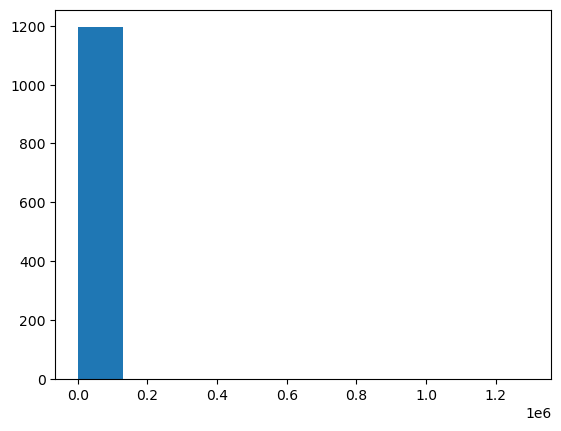

In [9]:
plt.hist(orders['revenue'])
plt.show()

In [10]:
print(orders.query('group == "A"').shape, 'A-group')
print(orders.query('group == "B"').shape, 'B-group')

(557, 5) A-group
(640, 5) B-group


Данные поделены в соотношении 47 к 53.

In [11]:
print(visitors.info())
visitors.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


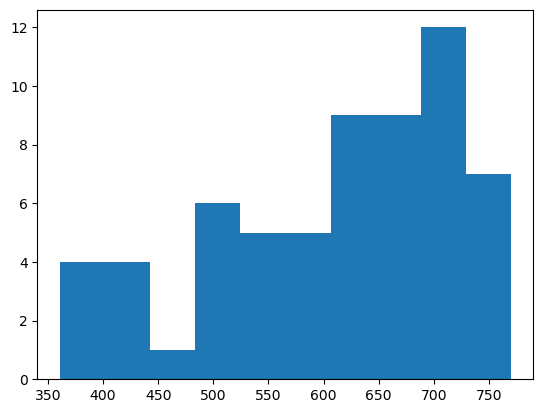

In [12]:
plt.hist(visitors['visitors'])
plt.show()

In [13]:
orders['date'] = pd.to_datetime(orders['date']).dt.date
visitors['date'] = pd.to_datetime(visitors['date']).dt.date

In [14]:
print(orders.loc[orders['group']=='A' ,'date'].min(), 'min orders date GROUP_A')
print(orders.loc[orders['group']=='B' ,'date'].min(), 'min orders date GROUP_B')
print(visitors.loc[visitors['group']=='A' ,'date'].min(), 'min visitors date GROUP_A')
print(visitors.loc[visitors['group']=='B' ,'date'].min(), 'min visitors date GROUP_B')
print()
print(orders.loc[orders['group']=='A' ,'date'].max(), 'max orders date GROUP_A')
print(orders.loc[orders['group']=='B' ,'date'].max(), 'max orders date GROUP_B')
print(visitors.loc[visitors['group']=='A' ,'date'].max(), 'max visitors date GROUP_A')
print(visitors.loc[visitors['group']=='B' ,'date'].max(), 'max visitors date GROUP_B')

2019-08-01 min orders date GROUP_A
2019-08-01 min orders date GROUP_B
2019-08-01 min visitors date GROUP_A
2019-08-01 min visitors date GROUP_B

2019-08-31 max orders date GROUP_A
2019-08-31 max orders date GROUP_B
2019-08-31 max visitors date GROUP_A
2019-08-31 max visitors date GROUP_B


In [15]:
print(visitors.query('group == "A"').shape, 'A-group')
print(visitors.query('group == "B"').shape, 'B-group')

(31, 3) A-group
(31, 3) B-group


In [16]:
groupa = orders.query('group == "A"')
groupb = orders.query('group == "B"')
print(groupa.loc[groupa['visitorId'].isin(groupb['visitorId']), 'visitorId'].nunique())

58


Присутствуют пользователи, попавшие в обе группы. Так как их количество не велико по сравнению с размером групп, а оценить влияние этих пользователей на результаты теста за ранее невозможно, принято решение оставить их.

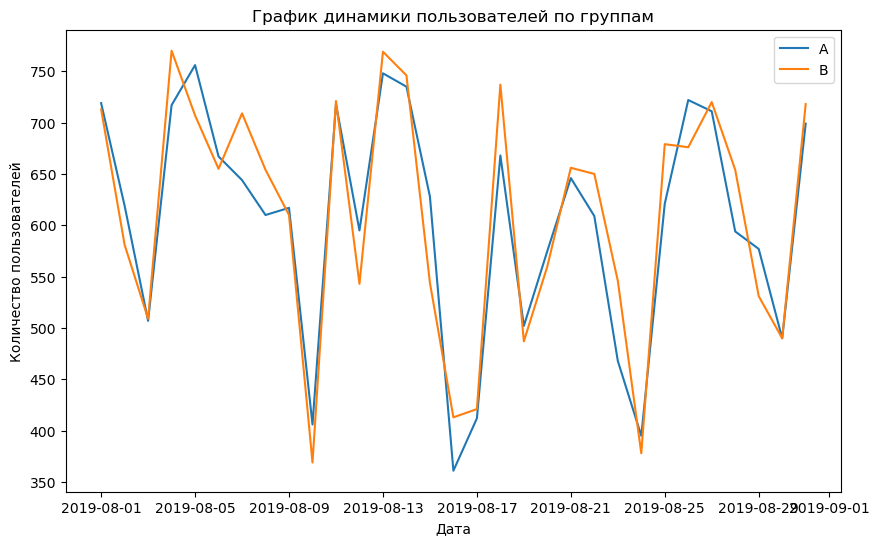

In [17]:
visitorsa = visitors[visitors['group'] == 'A'].groupby('date', as_index=False)['visitors'].sum()
visitorsb = visitors[visitors['group'] == 'B'].groupby('date', as_index=False)['visitors'].sum()
plt.figure(figsize=(10, 6))
plt.plot(visitorsa['date'], visitorsa['visitors'], label="A")
plt.plot(visitorsb['date'], visitorsb['visitors'], label="B")
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('График динамики пользователей по группам')
plt.legend()
plt.show()

В результатах A/B-теста пропусков, дубликатов и аномалий не обнаружено, минимальная и максимальная дата между группами ровны, данные готовы к дальнейшему исследованию. Следует заметить наличие выбросов в поле с выручкой значение - значение более 1.2млн рублей.

### Сбор и расчет метрик

In [18]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

         date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0  2019-08-01              24           148579              21   
1  2019-08-02              20            93822              24   
2  2019-08-03              24           112473              16   
3  2019-08-04              16            70825              17   
4  2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61           

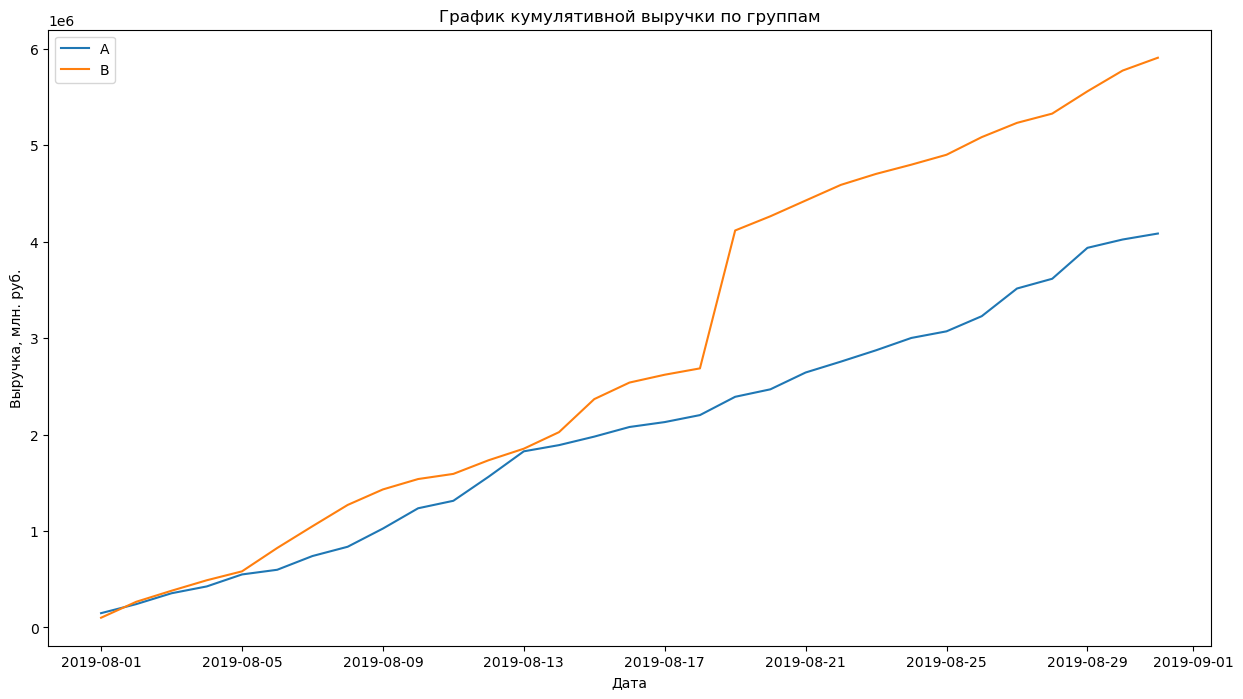

In [19]:
plt.figure(figsize=(15, 8))
plt.plot(data['date'], data['revenueCummulativeA'], label="A")
plt.plot(data['date'], data['revenueCummulativeB'], label="B")
plt.xlabel('Дата')
plt.ylabel('Выручка, млн. руб.')
plt.title('График кумулятивной выручки по группам')
plt.legend()
plt.show()

В начале теста были колебания у обоих групп, к середине теста уже виден явный фаворит - группа B. Также видно резкое увеличение выручки группы В 19 числа, что вероятнее всего связано с выбросами, появившимся по двум возможным причинам: увеличилось число покупок, т.е. конверсия пользователей в группе В и/или появились аномально дорогие покупки в этой же группе.

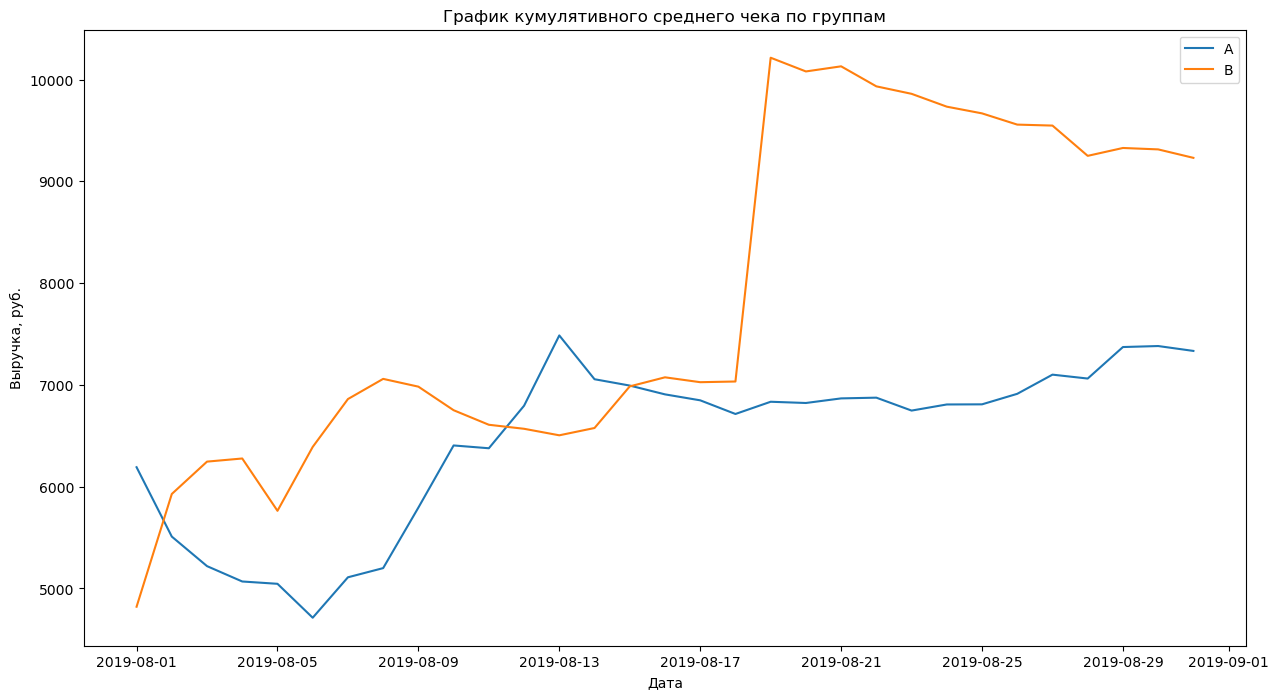

In [20]:
plt.figure(figsize=(15, 8))
plt.plot(data['date'], data['revenueCummulativeA']/data['ordersCummulativeA'], label="A")
plt.plot(data['date'], data['revenueCummulativeB']/data['ordersCummulativeB'], label="B")
plt.xlabel('Дата')
plt.ylabel('Выручка, руб.')
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.show()

Видны сильные колебания у обеих групп с начала и до середины теста. На графике кумулятивного среднего чека пользователей виден такой же характерный всплеск у группы В 19 числа, как и на графике кумулятивной выручки, после чего конверсия конверсия группы В падает, а группы А наоборот возростает.

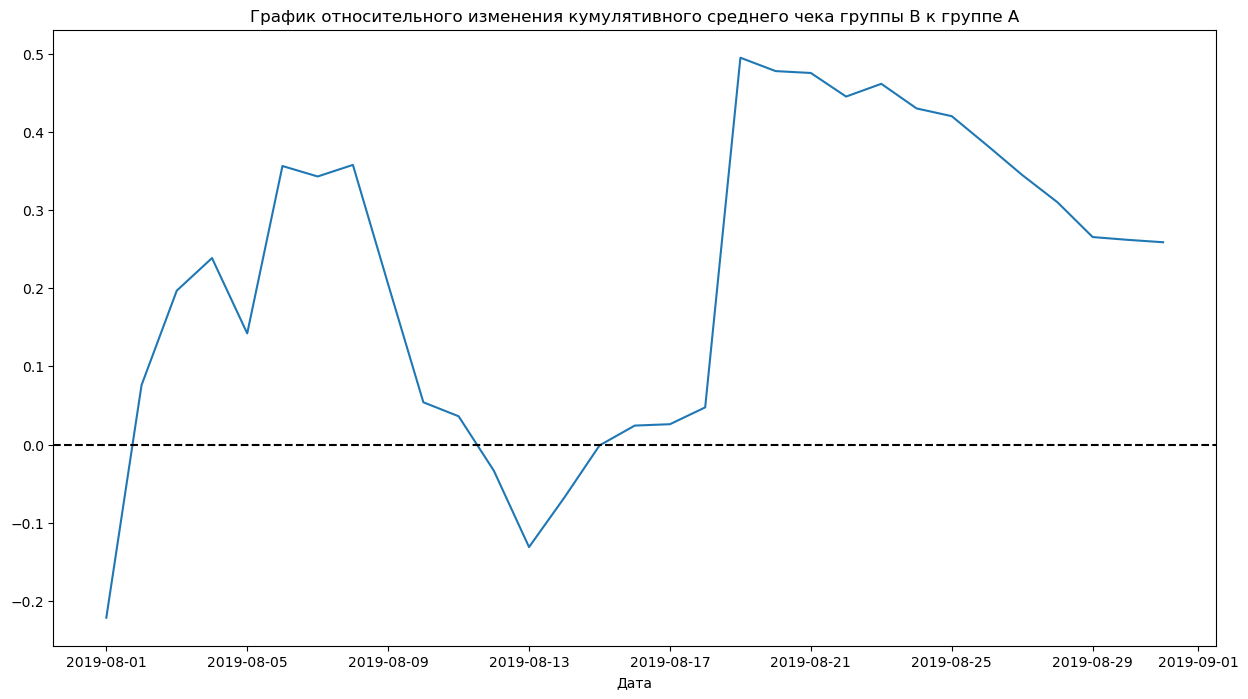

In [21]:
plt.figure(figsize=(15, 8))
plt.plot(
    data['date'], (data['revenueCummulativeB']/data['ordersCummulativeB'])/
    (data['revenueCummulativeA']/data['ordersCummulativeA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

Как и на графике кумулятивного среднего чека по группам, на график относительного изменения видны колебания у обеих групп до середины теста и после сильного всплеска 19-го числа разница между обеими группами сокращается.

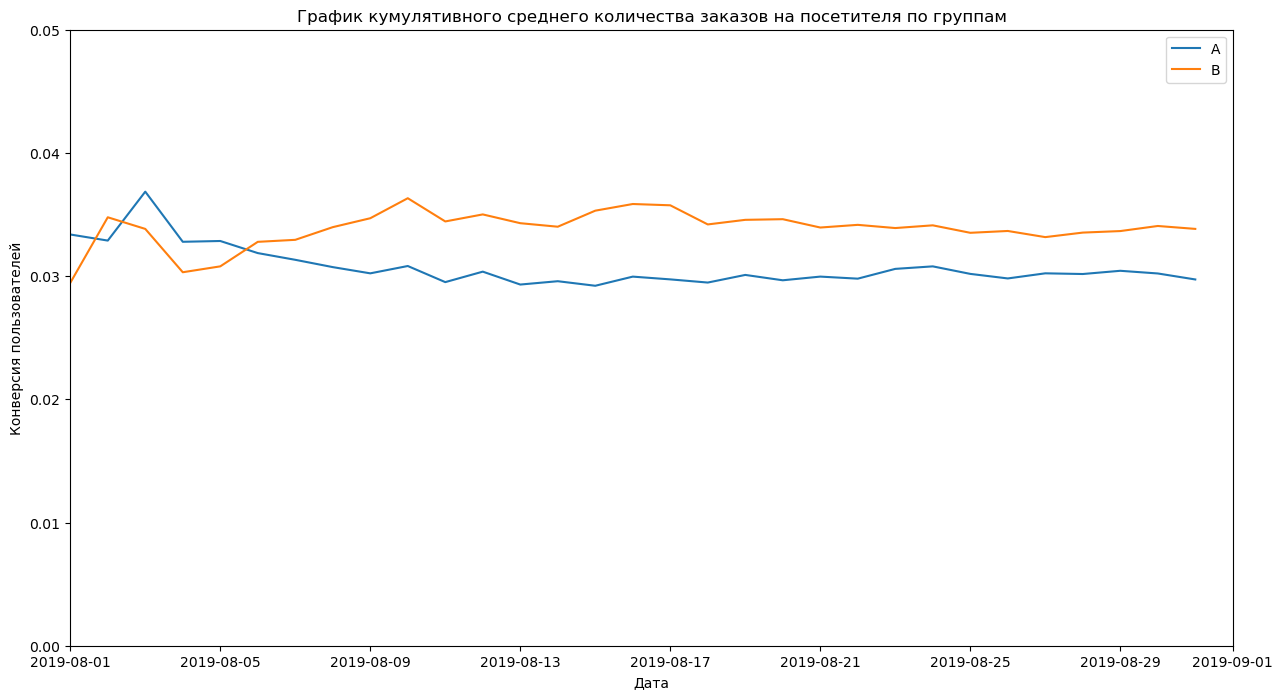

In [22]:
plt.figure(figsize=(15, 8))
plt.plot(data['date'], data['ordersCummulativeA']/data['visitorsCummulativeA'], label="A")
plt.plot(data['date'], data['ordersCummulativeB']/data['visitorsCummulativeB'], label="B")
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Конверсия пользователей')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
plt.show()

С начала теста группа А слегка выигрывала по конверсии пользователей, после чего группа В взяла лидерство и стабильно вела по конверсии на 2-5% до завершения теста.

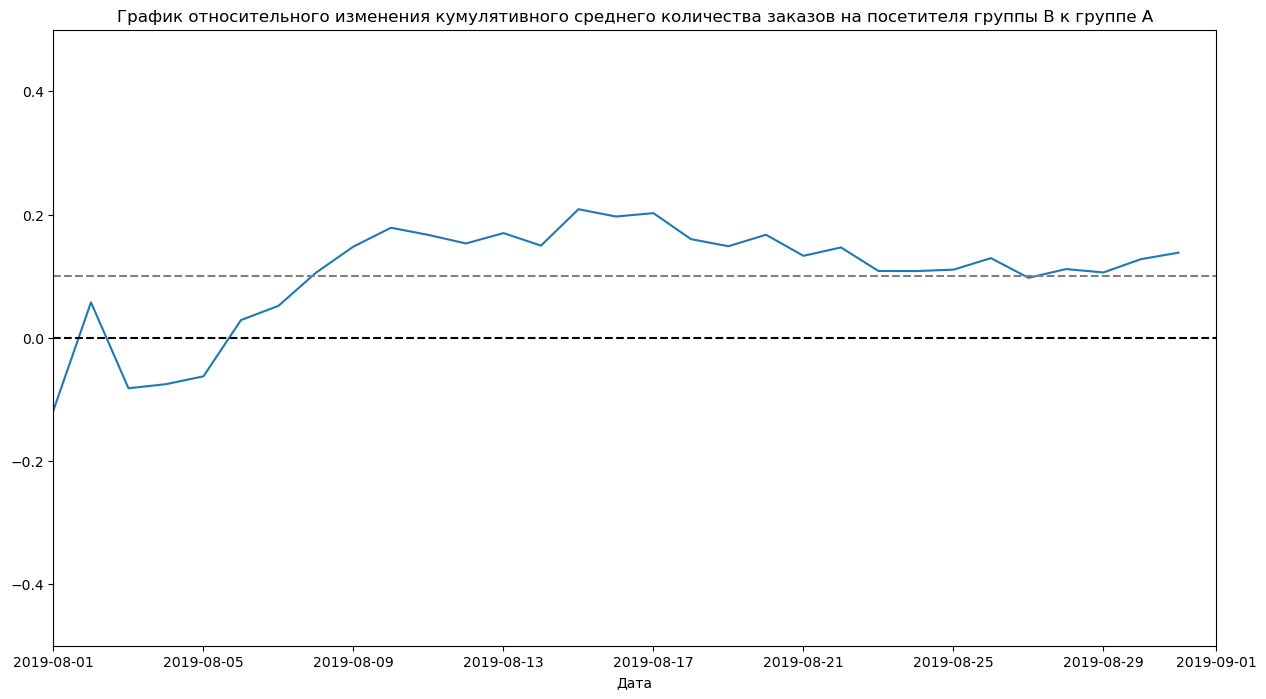

In [23]:
plt.figure(figsize=(15, 8))
plt.plot(data['date'], (
    data['ordersCummulativeB']/data['visitorsCummulativeB'])
    /(data['ordersCummulativeA']/data['visitorsCummulativeA'])-1)
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.5, 0.5])
plt.show()

К 6-му числу отношение конверсии склонилось в сторону группы В и с того момента стабильно выше отметки 10% до самого конца теста.

Исходя из графиков кумулятивных конверсии и среднего чека на пользователя по "сырым" данным, группа В с небольшим отрывом выигрывает у группы А по обоим показателям.

### Поиск аномалий и выбросов

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


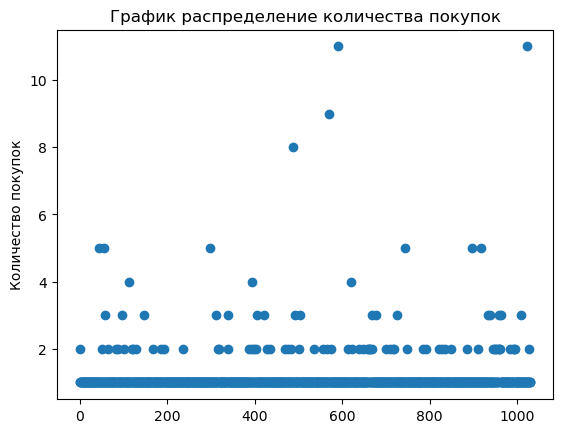

In [24]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns = ['userId', 'orders']
print(ordersByUsers.sort_values('orders', ascending=False).head(10))
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('График распределение количества покупок')
plt.ylabel('Количество покупок')
plt.show()

Среди пользователей присутствуют те, что сделали 8, 9, и даже 11 покупок. Посчитаем перцентили количества заказов на пользователя, чтобы понять, каких пользователей следует убрать.

In [25]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершили более двух заказов. И не более одного процента пользователей - больше 4 заказов.

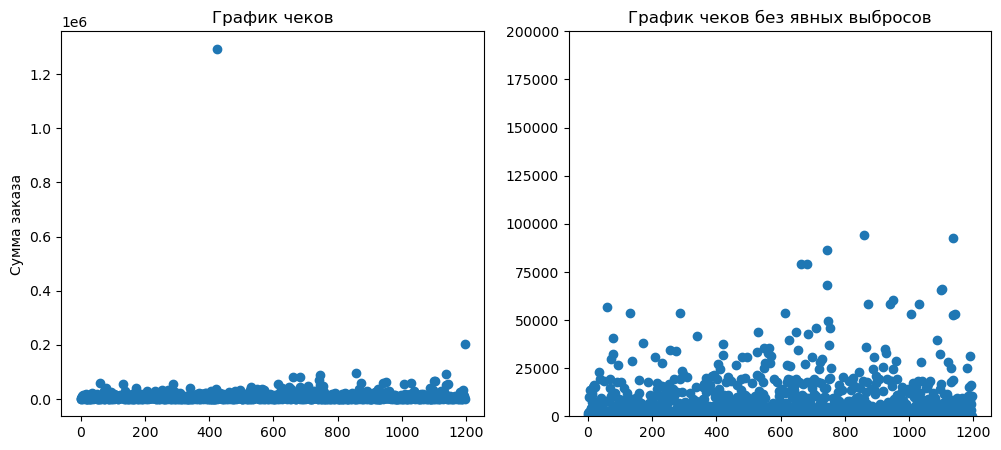

In [26]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Сумма заказа')
plt.title('График чеков')
plt.subplot(122)
plt.scatter(x_values, orders['revenue'])
plt.ylim(0,200000)
plt.title('График чеков без явных выбросов')
plt.show()

В поле с чеками покупок есть пара ярко выраженных выбросов - около 200т. рублей и более 1.2млн. рублей.

In [27]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% пользователей сделали покупку на сумму более 28 тыс. Не более одного процента пользователей сделали покупку на сумму более 60 тыс.

Таким образом за аномалии возьмем пользователей с числом заказов более 3 и пользователей, совершивших покупку на сумму более 60 тыс. рублей.

### Расчет статистической значимости

#### Проверка гипотез по сырым данным

**Гипотеза №1**

За **нулевую гипотезу(H0)** примем конверсии пользователей в платящих между группами одинаковыми. За **алтернативную возьмем(H1)** соответственно конверсии между группами отличными. За критический уровень статистической значимости возьмем **alpha = 0,05**.

In [28]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsersB.columns = ['userId', 'orders']
sampleA = pd.concat(
    [ordersByUsersA['orders'], pd.Series(
        0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders'
    )],axis=0
)
sampleB = pd.concat(
    [ordersByUsersB['orders'], pd.Series(
        0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders'
    )],axis=0
)

In [29]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


Анализ сырых данных показывает, что статистически значимые отличия между группами есть, поскольку p-value меньше альфа. Относительный прирост среднего группы В к конверсии группы А равен 13.8%

**Гипотеза №2**

За **нулевую гипотезу(H0)** примем чеки пользователей между группами одинаковыми. За **алтернативную(H1)** возьмем соответственно чеки между группами отличными. За критический уровень статистической значимости возьмем **alpha = 0,05**.

In [30]:
print("{0:.5f}".format(
    stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.72929
0.259


P-value больше 0.05 - статистически значимых отличий в средних чеках нет, однако относительное различие среднего чека между группами есть - 25.9%, что говорит об ошибке второго рода - ложнонегативном результате. Скорее всего это вызвано выбросами в группе В, которые были выявлены ранее.

#### Проверка гипотез по очищенным данным


По аналогии с "сырыми" данными, для очищенных от выбросов данных возьмем за нулевые гипотезы конверсии пользователей и чеки пользователей соответственно одинаковыми. Альтернативными гипотезами также будут конверсии и чеки пользователей между группами отличными. Alpha = 0.05

In [31]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId']
    ], axis=0
)

usersWithExpensiveOrders = orders[orders['revenue'] > 60000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

In [32]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
    ], axis=0
)
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')
    ], axis=0
)

In [33]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.013
0.153


Как и в случае с сырыми данными, стат. значимые отличия между группами присутствуют. Конверсия группы В значительно лучше группы А.

In [34]:
print("{0:.5f}".format(stats.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]
                      ))
print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',
                          np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(orders['group']=='A',
                          np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))

0.92077
-0.001


Анализ чеков по очищенным данным показывает, что статистически значимых отличий между группами нет и относительное различие средних чеков незначительно - всего 0.1%.

Обобщая результаты анализа конверсии и средних чеков между группами:
 - Конверсия пользователей в группе В к концу теста выше группы А примерно на 15% и в сырых, и в фильтрованных данных.
 - По результатам анализа очищенных данных различий между группами в средних чеках не обнаружено.

## Выводы

Используя фреймворки приоритизации, мы нашли наиболее приорететную для проведения A/B-теста гипотезу - "добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

После получения результатов, была проведена исследовательская работа с сырыми данными A/B-теста, в ходе которой были обнаружены выбросы в чеках и количестве покупок на пользователя, а также пользователи находящиеся в обех группах.

Поскольку гипотезы были проверены по U-критерию Манна — Уитни, неравномерное распределение пользователей по группам не искажает результаты исследований. Количество пользователей находящихся в обех группах не велико, поэтому было принято решение оставить их. Исследование гипотез было проведено с учетом выбросов, а также по фильтрованным данным.

Подводя итоги:
 1. Статистически значимые различия в конверсии достингуты - группа В большую часть теста ведет уверенное лидерство.
 2. Различия в средних чеках между группами не достигнуты.

Исходя из фактов выше, принято решение о завершении A/B-теста. Так как результаты по одному из параметров улучшились, а по другому не изменились, можно считать A/B-тест успешными и внедрять новую фичу в проект.